# Problem Set 3: Geometry
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 1. Calibration

In [3]:
## Load dataset
# Points in image A
with open('pts2d-pic_a.txt', 'r') as f:
    pts2d_a = np.array([[int(n) for n in line.split()] for line in f])
# Points in image B
with open('pts2d-pic_b.txt', 'r') as f:
    pts2d_b = np.array([[int(n) for n in line.split()] for line in f])
# Points in 3D space
with open('pts3d.txt', 'r') as f:
    pts3d = np.array([[float(n) for n in line.split()] for line in f])
# Normalized points in image A
with open('pts2d-norm-pic_a.txt', 'r') as f:
    pts2d_norm_a = np.array([[float(n) for n in line.split()] for line in f])
# Normalized points in 3D space
with open('pts3d-norm.txt', 'r') as f:
    pts3d_norm = np.array([[float(n) for n in line.split()] for line in f])

### 1.1 Projection Matrix (M) using least squares

In [4]:
def projection_matrix_lsq(pts2d, pts3d):
    '''
    Camera calibration: Calculate the projection matrix M that transforms points 
    from the 3D world frame to the 2D image frame.
    
    Assumes the last entry of M equal to 1 (M32 = 1) to find the least squares 
    solution to the linear correspondence equations.
    '''
    # Dims
    num_points = pts3d.shape[0]
    num_variables = 11
    # AM = b
    A = np.zeros((2*num_points, num_variables), dtype=np.float)
    b = np.zeros((2*num_points), dtype=np.float)
    # Form set of linear equations
    for ix, ([u, v], [x, y, z]) in enumerate(zip(pts2d, pts3d)):
        A[2*ix, :]   = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]
        A[2*ix+1, :] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z]
        b[2*ix]      = u
        b[2*ix+1]    = v
    # Solve for M
    # M = (A'A)^-1.A'b
    M = np.linalg.inv(A.T@A) @ A.T @ b
    # M = np.linalg.lstsq(A, b)[0]
    M = np.append(M, 1).reshape((3, 4))
    return M

In [5]:
# Calculate projection matrix M
M = projection_matrix_lsq(pts2d_norm_a, pts3d_norm)
print(M)

[[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]


In [6]:
pt_3d = pts3d_norm[-1].copy()
print('Coordinates of point in 3D (x, y, z)   : ({:.4f}, {:7.4f}, {:7.4f})'.format(*pt_3d))
pt_3d = np.append(pt_3d, 1)
us, vs, s = M @ pt_3d
print('Calculated coordinates in Image (u, v) : ({:.4f}, {:7.4f})'.format(us/s, vs/s))
u, v = pts2d_norm_a[-1]
print('Actual coordinates in Image (u, v)     : ({:.4f}, {:7.4f})'.format(u, v))
resid = np.sqrt((u-us/s)**2 + (v-vs/s)**2)
print('Calculated residue                     :  {:.4f}'.format(resid))

Coordinates of point in 3D (x, y, z)   : (1.2323,  1.4421,  0.4506)
Calculated coordinates in Image (u, v) : (0.1419, -0.4518)
Actual coordinates in Image (u, v)     : (0.1406, -0.4527)
Calculated residue                     :  0.0016


### 1.2 Random Sampling

In [7]:
def sample_projection_matrix(pts2d, pts3d, train_size, val_size, num_iters=10):
    '''
    Randomly sample 'train_size' points and calculate the projection matrix M
    using least squares.
    Returns M which has lowest average residual among validation points.
    '''
    # Number of points in the dataset
    num_points = pts3d.shape[0]
    # Initializations
    min_avg_resid = np.inf
    for it in range(num_iters):
        print('-' * 30)
        perm = np.random.permutation(num_points)
        # Common validation set
        val_ix = perm[:val_size]
        for k in train_size:
            # Randomly split data
            train_ix = np.random.permutation(perm[val_size:])[:k]
            # Calculate projection matrix
            pts2d_train = pts2d[train_ix]
            pts3d_train = pts3d[train_ix]
            M_sample = projection_matrix_lsq(pts2d_train, pts3d_train)
            # Project points in validation set
            pts3d_val = pts3d[val_ix]
            pts3d_val = np.column_stack((pts3d_val, np.ones(pts3d_val.shape[0])))
            proj = (M_sample @ pts3d_val.T).T
            u_calc, v_calc = proj[:, 0]/proj[:, -1], proj[:, 1]/proj[:, -1]
            # Calculate error from ground truth
            u, v = pts2d[val_ix, 0], pts2d[val_ix, 1]
            resid = np.sqrt((u-u_calc)**2 + (v-v_calc)**2)
            # Store best value
            avg_resid = np.mean(resid)
            if avg_resid < min_avg_resid:
                min_avg_resid = avg_resid
                M_best = M_sample
            print('#{:d}: k={:02d}, residual={:0.2f}'.format(it, k, avg_resid))
    return M_best

Msample = sample_projection_matrix(pts2d_b, pts3d, train_size=[8, 12, 16], val_size=4)

------------------------------
#0: k=08, residual=2.26
#0: k=12, residual=1.36
#0: k=16, residual=1.17
------------------------------
#1: k=08, residual=2.49
#1: k=12, residual=1.66
#1: k=16, residual=1.32
------------------------------
#2: k=08, residual=4.11
#2: k=12, residual=1.01
#2: k=16, residual=0.99
------------------------------
#3: k=08, residual=10.45
#3: k=12, residual=1.84
#3: k=16, residual=1.64
------------------------------
#4: k=08, residual=3.13
#4: k=12, residual=1.20
#4: k=16, residual=1.01
------------------------------
#5: k=08, residual=4.33
#5: k=12, residual=2.18
#5: k=16, residual=1.60
------------------------------
#6: k=08, residual=2.32
#6: k=12, residual=1.42
#6: k=16, residual=1.32
------------------------------
#7: k=08, residual=1.17
#7: k=12, residual=1.30
#7: k=16, residual=0.92
------------------------------
#8: k=08, residual=2.87
#8: k=12, residual=1.14
#8: k=16, residual=0.74
------------------------------
#9: k=08, residual=5.16
#9: k=12, residua

We can see that more points usually correspond to a lower average residual. This is because the noise is averaged out while calculating the projection matrix. There are some exceptions because a bigger set has a higher probability of containing an outlier.

In [8]:
print(Msample)

[[-2.04758636e+00  1.18769121e+00  3.97419564e-01  2.43690416e+02]
 [-4.56172395e-01 -3.01851858e-01  2.14893442e+00  1.65605377e+02]
 [-2.24559883e-03 -1.09542484e-03  5.62627035e-04  1.00000000e+00]]


### 1.3 Camera Center

In [9]:
def camera_center(M):
    '''
    Calculate camera center from the projection matrix.
    M = [Q | m4]
    C = -Q^-1 * m4
    '''
    Q = M[:, :3]
    m4 = M[:, 3]
    C = -np.linalg.inv(Q) @ m4
    return C

C = camera_center(Msample)
print('Coordinates of camera center (x, y, z): ({:.4f}, {:7.4f}, {:7.4f})'.format(*C))

Coordinates of camera center (x, y, z): (303.0946, 307.1764, 30.4243)


---
## 2. Fundamental Matrix
### 2.1 Calculation using SVD

In [10]:
def fundamental_matrix_svd(pts_a, pts_b):
    '''
    Calculate fundamental matrix that transforms points from the homogenous 
    2D coordinate frame a to homogenous 2D coordinate frame b.
    Uses a sample of point correspondences among an image pair.
    '''
    # Dims
    num_points = pts_a.shape[0]
    num_variables = 9
    # AF = 0
    A = np.zeros((num_points, num_variables), dtype=np.float)
    # Form set of linear equations
    for ix, ([u1, v1], [u2, v2]) in enumerate(zip(pts_a, pts_b)):
        A[ix, :] = [u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1]
    # Solve for F subject to |F| = 1 (SVD Trick)
    u, s, vt = np.linalg.svd(A.T @ A)
    F = vt[-1, :].reshape((3, 3))
    return F

In [11]:
F = fundamental_matrix_svd(pts2d_a, pts2d_b)
print(F)

[[-6.60698417e-07  7.91031620e-06 -1.88600197e-03]
 [ 8.82396296e-06  1.21382933e-06  1.72332901e-02]
 [-9.07382303e-04 -2.64234650e-02  9.99500092e-01]]


### 2.2 Rank Constraint

In [12]:
def reduce_rank(A, rank):
    '''
    Get a low rank approximation of A.
    '''
    assert(rank < min(A.shape))
    # U*S*V'
    u, s, vt = np.linalg.svd(A)
    # Select top 'rank' singular values
    A = (u[:, :rank]*s[:rank]) @ vt[:rank, :]
    return A

In [13]:
F = reduce_rank(F, rank=2)
print(F)

[[-5.36264198e-07  7.90364770e-06 -1.88600204e-03]
 [ 8.83539184e-06  1.21321685e-06  1.72332901e-02]
 [-9.07382265e-04 -2.64234650e-02  9.99500092e-01]]


### 2.3 Epipolar Lines

In [14]:
## Load image B
imgb = cv2.imread('pic_b.jpg')
## OpenCV BGR to RGB
imgb = imgb[:,:,::-1]

In [15]:
def get_epipolar_lines(pts, F):
    '''
    Calculate equations of corresponding epipolar lines of input
    points using the input fundamental matrix.
    '''
    pts_hg = np.column_stack((pts, np.ones(pts.shape[0])))    
    lines = (F @ pts_hg.T).T
    return lines

def plot_epipolar_lines(ax, lines, img):
    # Dims
    h, w = imgb.shape[:-1]
    # Left and right edge lines
    edge_l = np.array([1, 0, 0])
    edge_r = np.array([-1, 0, w])
    for ln in lines:
        # p = l1 x l2
        pt_l = np.cross(ln, edge_l)
        pt_r = np.cross(ln, edge_r)
        # Homogeneous to pixel
        xl, yl = pt_l[0]/pt_l[2], pt_l[1]/pt_l[2]
        xr, yr = pt_r[0]/pt_r[2], pt_r[1]/pt_r[2]
        # Plot line
        ax.plot([xl, xr], [yl, yr], 'b')
    return

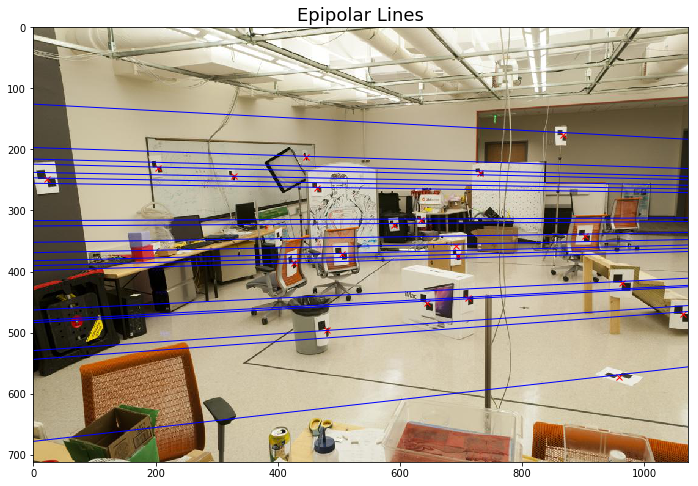

In [16]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.set_title('Epipolar Lines')
ax.imshow(imgb);
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
# Label points
ax.plot(pts2d_b[:, 0], pts2d_b[:, 1], 'rx')
# Epipolar lines
lines = get_epipolar_lines(pts2d_a, F)
plot_epipolar_lines(ax, lines, imgb)

### 2.4x Normalization

In [17]:
def normalize(pts2d):
    '''
    Center and scale image coordinates.
    '''
    # Params
    u_mean, v_mean = np.mean(pts2d, axis=0)
    u_std, v_std = np.std(pts2d, axis=0)
    # Transformation matrix
    T = np.array([[1/u_std, 0,       -u_mean/u_std],
                  [0,       1/v_std, -v_mean/v_std],
                  [0,       0,       1            ]])
    # Pixedl to homogeneous
    pts2d_hg = np.column_stack((pts2d, np.ones(pts2d.shape[0])))
    # p' = Tp
    pts2d_norm = (T @ pts2d_hg.T).T
    return pts2d_norm[:, :-1], T

In [18]:
# Normalize points
pts2d_an, Ta = normalize(pts2d_a)
pts2d_bn, Tb = normalize(pts2d_b)
# Calculate normlized fundamental matrix
F_hat = fundamental_matrix_svd(pts2d_an, pts2d_bn)
F_hat = reduce_rank(F_hat, rank=2)
# Inverse transformation
F = Tb.T @ F_hat @ Ta
print(F)

[[ 2.02478523e-07 -2.78039315e-06  6.94781145e-04]
 [-1.92581510e-06  4.74398800e-07 -5.59813726e-03]
 [ 4.16157075e-05  7.69192568e-03 -1.78588215e-01]]


### 2.5x Epipolar lines after normalization

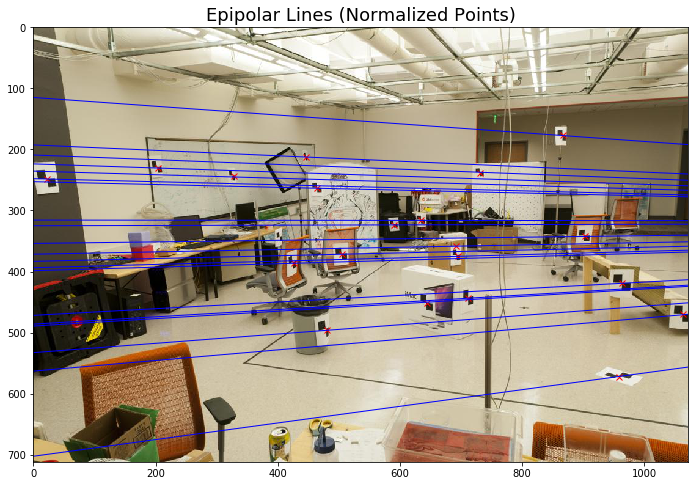

In [19]:
# Plot
fig, ax = plt.subplots(1, 1)
ax.set_title('Epipolar Lines (Normalized Points)')
ax.imshow(imgb);
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
# Label points
ax.plot(pts2d_b[:, 0], pts2d_b[:, 1], 'rx')
# Epipolar lines
lines = get_epipolar_lines(pts2d_a, F)
plot_epipolar_lines(ax, lines, imgb)